## Goal
As a first pass at developing a machine learning model to predict California wildfires I will evaluate and tune several different gradient boosting algorithms. The procedure will be as follows:

1. **Classifier selection:** Find the best classification algorithm for the data based on F1 score compute time and memory requirements
2. **Metaparameter optimization:** Optimize data metaparameters such as rolling window width
3. **Class imbalance:** Generate a strategy to deal with the unbalanced nature of the classes
4. **Hyperparameter optimization:** Tune model hyperparameters
5. **Feature importance:** Investigate feature importance and possibly trim/apply dimensionality reduction techniques to the data
6. **Model robustness:** How does the model perform after repeated sampling? Are scores stable?

There are two anticipated issues which will need to be dealt with first:

1. Large dataset size - current working dataset has 7.3 million observations of 25 variables and this is likely to grow as the project progresses
2. Highly imbalanced data (~20 times more observations without fire than with)

Future goals are to add several more factors from various data sources including: elevation, population density, time since last fire and total fires.

In [1]:
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
from statistics import mean
from memory_profiler import memory_usage
from scipy.interpolate import griddata

#from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.utils.fixes import loguniform

import helper_functions.data_functions as data_functions
import helper_functions.plotting_functions as plotting_functions

%matplotlib inline
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [2]:
# Variables

raw_data_file = '/mnt/SSD/data/training_data/1992-2015_california.parquet'

rand_seed = 42
classifier_jobs = 4
optimization_jobs = 2
max_jobs = classifier_jobs * optimization_jobs

sample_size = 10000
repetitions = 3
train_test_split_ratio = 0.3
cv_folds = 3
n_doublings = 4
scoring_func = make_scorer(f1_score)
scoring_func_name = "F1 score"
grid_search_iterations = 10

plot_grid_resolution = 500
contourf_levels = 500

weather_variables = [
    'lat',
    'lon',
    'month',
    'air.2m',
    'apcp',
    'rhum_2m',
    'dpt_2m',
    'pres_sfc',
    'uwnd_10m',
    'vwnd_10m',
    'vis',
    'lcdc',
    'hcdc',
    'mcdc',
    'crain',
    'veg',
    'ignition'
]

## Data preparation

In [3]:
# Load data
raw_data = pd.read_parquet(raw_data_file)
raw_data['year'] = raw_data['date_time'].dt.year.astype('float32')
raw_data['month'] = raw_data['date_time'].dt.month.astype('float32')
raw_data['day'] = raw_data['date_time'].dt.day.astype('float32')
raw_data = raw_data.sample(frac=1).reset_index(drop=True)

raw_data.info()

/home/siderealyear/anaconda3/envs/wildfire_production/lib/python3.7/site-packages/fastparquet/encoding.py:222: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  Numpy8 = numba.jitclass(spec8)(NumpyIO)
/home/siderealyear/anaconda3/envs/wildfire_production/lib/python3.7/site-packages/fastparquet/encoding.py:224: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  Numpy32 = numba.jitclass(spec32)(NumpyIO)
/home/side

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28752480 entries, 0 to 28752479
Data columns (total 20 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date_time  datetime64[ns]
 1   lat        float32       
 2   lon        float32       
 3   air.2m     float32       
 4   apcp       float32       
 5   crain      float32       
 6   rhum_2m    float32       
 7   dpt_2m     float32       
 8   pres_sfc   float32       
 9   uwnd_10m   float32       
 10  vwnd_10m   float32       
 11  veg        float32       
 12  lcdc       float32       
 13  hcdc       float32       
 14  mcdc       float32       
 15  vis        float32       
 16  ignition   float32       
 17  year       float32       
 18  month      float32       
 19  day        float32       
dtypes: datetime64[ns](1), float32(19)
memory usage: 2.2 GB


In [4]:
data = raw_data[weather_variables]

# Shuffel row order
data = data.sample(frac=1).reset_index(drop=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28752480 entries, 0 to 28752479
Data columns (total 17 columns):
 #   Column    Dtype  
---  ------    -----  
 0   lat       float32
 1   lon       float32
 2   month     float32
 3   air.2m    float32
 4   apcp      float32
 5   rhum_2m   float32
 6   dpt_2m    float32
 7   pres_sfc  float32
 8   uwnd_10m  float32
 9   vwnd_10m  float32
 10  vis       float32
 11  lcdc      float32
 12  hcdc      float32
 13  mcdc      float32
 14  crain     float32
 15  veg       float32
 16  ignition  float32
dtypes: float32(17)
memory usage: 1.8 GB


## Classifier selection: kitchen sink approach

First step is to throw a bunch of different classifiers with default settings at the problem and see how they do. See list below for contenders.

We will start with a small sample of data to quickly get a sense of how well each classifier works. Hopefully we can discard some to make test run times shorter in the next round.

In [5]:
# SKLearn classifiers

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# List of classifier descriptions for plotting / dataframes
classifier_descriptions = [
    'Logit. regres.',
    'Decision tree',
    'K neighbors',
    'Rand. forest',
    'QDA',
    'XGBoost',
    'CatBoost',
    'LightGBM',
    'AdaBoost',
    'Linear SVM',
    'RBF SVM',
    'Naive Bayes'
]

# Classifiers with parameters. Set parallism and rand_seed if avalible.
# Also set 'rule of thumb' class weight if avalible for that classifier.

num_negative_observations = len(raw_data[raw_data['ignition'] == 0])
num_positive_observations = len(raw_data[raw_data['ignition'] == 1])
class_ratio = num_negative_observations / num_positive_observations

class_weight_dict = {
    0: 1,
    1: class_ratio
}

classifiers = (
    
    LogisticRegression(
        n_jobs = max_jobs, 
        random_state = rand_seed,
        class_weight = class_weight_dict
    ),
    
    DecisionTreeClassifier( 
        random_state = rand_seed,
        class_weight = class_weight_dict
    ),
    
    KNeighborsClassifier(
        n_jobs = max_jobs        
    ),
    
    RandomForestClassifier(
        n_jobs = max_jobs,
        class_weight = class_weight_dict,
        random_state = rand_seed
    ),
    
    QuadraticDiscriminantAnalysis(),
    
    XGBClassifier(
        n_jobs = max_jobs,
        scale_pos_weight = class_ratio,
        random_state = rand_seed
    ),
    
    CatBoostClassifier(
        thread_count = max_jobs, 
        silent = True,
        scale_pos_weight = class_ratio,
        random_state = rand_seed
    ),
    
    LGBMClassifier(
        n_jobs = max_jobs,
        scale_pos_weight = class_ratio,
        random_state = rand_seed
    ),
    
    AdaBoostClassifier(random_state = rand_seed),
    
    SVC(kernel = "linear",
        class_weight = 'balanced',
        random_state = rand_seed
    ),
    
    SVC(
        class_weight = 'balanced',
        random_state = rand_seed
    ),
    
    GaussianNB(),
)

In [6]:
# Loop over classifier list, run k-fold cross validation on stratified 
# training sample for each. Report mean and SD of score, run time and peak memory use

# Start empty dataframe to hold results
classifier_data = pd.DataFrame(columns=[
    'Classifier',
    'Sample size',
    'CV folds',
    'Raw scores',
    'Mean {} score'.format(scoring_func_name),
    '{} score SD'.format(scoring_func_name),
    'Peak memory (GB)',
    'Run time (min.)'
])

# Loop over classifiers
for classifier, description in zip(classifiers, classifier_descriptions):
    
    dTs = []
    max_mems = []
    raw_scores = []
    
    for i in range(repetitions):
        
        # Take stratified sample data of data and do stratified train_test split    
        X_train, X_test, y_train, y_test = data_functions.make_train_test_sample(
            data, 
            sample_size, 
            train_test_split_ratio, 
            rand_seed
        )
        
        start = time()

        # Cross validate classifier, tracking memory usage
        mem_usage, cross_val_scores = memory_usage((data_functions.cross_validate_classifier, (
            classifier, 
            X_train, 
            y_train, 
            cv_folds, 
            scoring_func)
        ), retval=True)

        dT = np.round(((time() - start)/60), 2)
        dTs.append(dT)
        raw_scores = np.concatenate((raw_scores, cross_val_scores))
        max_mems = np.concatenate((max_mems, mem_usage))

    mean_score = np.round(mean(raw_scores), 3)
    sd_score = np.round(np.std(raw_scores), 4)
    max_mem = np.round((max(max_mems) / 1000), 3)
    
    # Store run results in dataframe
    classifier_data = classifier_data.append(pd.Series([
        description,
        sample_size,
        cv_folds,
        cross_val_scores,
        mean_score,
        sd_score,
        max_mem,
        dT
    ], index=classifier_data.columns), ignore_index=True)
    
    print(f'Finished {description}, mean score: {mean_score}')

# Sort results by score
classifier_data = classifier_data.sort_values(['Mean {} score'.format(scoring_func_name)], ascending=[0])

Finished Logit. regres., mean score: 0.109
Finished Decision tree, mean score: 0.077
Finished K neighbors, mean score: 0.005
Finished Rand. forest, mean score: 0.0
Finished QDA, mean score: 0.117
Finished XGBoost, mean score: 0.083
Finished CatBoost, mean score: 0.107
Finished LightGBM, mean score: 0.097
Finished AdaBoost, mean score: 0.005
Finished Linear SVM, mean score: 0.096
Finished RBF SVM, mean score: 0.075
Finished Naive Bayes, mean score: 0.11


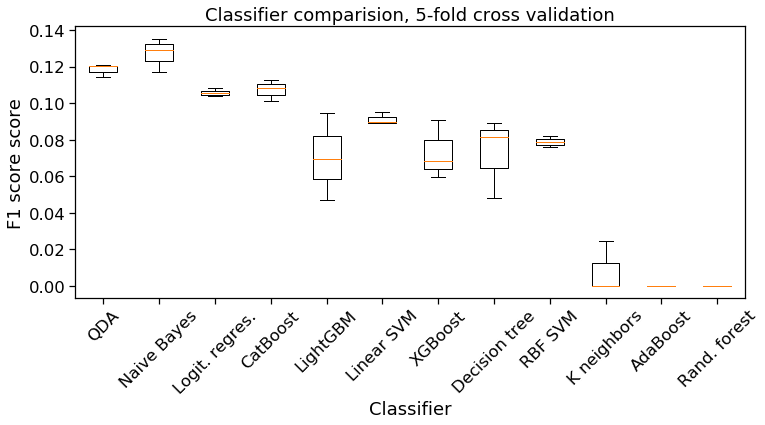

In [7]:
# Plot comparison of classifiers using mean score
fig = plt.figure(1, figsize=(12, 5))
ax = fig.add_subplot(111)

bp = ax.boxplot(classifier_data['Raw scores'])
ax.set_xticklabels(classifier_data['Classifier'])
plt.xlabel('Classifier')
plt.ylabel('{} score'.format(scoring_func_name))
plt.title('Classifier comparision, 5-fold cross validation')
plt.xticks(rotation=45)
plt.show()

In [8]:
classifier_data.drop('Raw scores', axis=1)

,Classifier,Sample size,CV folds,Mean F1 score score,F1 score score SD,Peak memory (GB),Run time (min.)
4,QDA,10000,3,0.117,0.0117,5.117,0.00
11,Naive Bayes,10000,3,0.110,0.0140,5.187,0.00
0,Logit. regres.,10000,3,0.109,0.0080,5.098,0.02
6,CatBoost,10000,3,0.107,0.0211,5.143,0.20
7,LightGBM,10000,3,0.097,0.0346,5.148,0.01
9,Linear SVM,10000,3,0.096,0.0063,5.204,0.47
5,XGBoost,10000,3,0.083,0.0303,5.116,0.02
1,Decision tree,10000,3,0.077,0.0211,5.099,0.01
10,RBF SVM,10000,3,0.075,0.0042,5.227,0.09
2,K neighbors,10000,3,0.005,0.0101,5.100,0.01


Not surprisingly, our top three winners are gradient boosting algorithms. All three are within a standard deviation of each other, but CatBoost takes ~15 times longer than the other two. Let's focus on the top three and quickly check how well they will scale as the dataset grows.

## Classifier selection: resource requirements

In [9]:
# Reduced classifier set

classifier_descriptions = [
    'LightGBM',
    'CatBoost',
    'XGBoost'
]

classifiers = (
    
    LGBMClassifier(
        n_jobs = max_jobs,
        scale_pos_weight = class_ratio,
        random_state = rand_seed
    ),
    
    CatBoostClassifier(
        thread_count = max_jobs, 
        silent = True,
        scale_pos_weight = class_ratio,
        random_state = rand_seed
    ),
    
    XGBClassifier(
        n_jobs = max_jobs,
        scale_pos_weight = class_ratio,
        random_state = rand_seed
    ),
)

In [10]:
sample_size_data = pd.DataFrame(columns=[
    'Classifier',
    'Sample size',
    'Peak memory (GB)',
    'Run time (min.)'
])

size_of_sample = 5000

# Loop over range n, doubling the size of the dataset sample each time
for i in range(0,(n_doublings+1)):
    
    # Loop over each classifier, store max memory and run time
    for classifier, description in zip(classifiers, classifier_descriptions):
    
        for i in range(repetitions):
            
            X_train, X_test, y_train, y_test = data_functions.make_train_test_sample(
                data, 
                size_of_sample, 
                train_test_split_ratio, 
                rand_seed
            )
            
            start = time()
            mem_usage, model = memory_usage((data_functions.fit_model, (classifier, X_train, y_train)), retval=True)
            dT = np.round(((time() - start)/60),2)

            max_mem = np.round((max(mem_usage) / 1000),3)

            sample_size_data = sample_size_data.append(pd.Series([
                description,
                size_of_sample,
                max_mem,
                dT
            ], index=sample_size_data.columns), ignore_index=True)
    
    size_of_sample = size_of_sample * 2

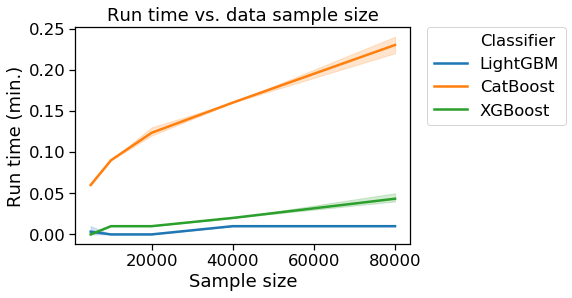

In [11]:
ax = sns.lineplot(x='Sample size', y='Run time (min.)', hue='Classifier', data=sample_size_data)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Run time vs. data sample size')
plt.show()

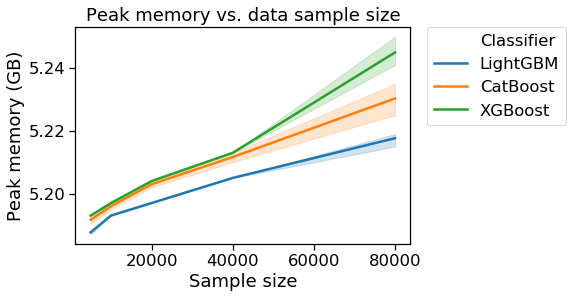

In [12]:
ax = sns.lineplot(x='Sample size', y='Peak memory (GB)', hue='Classifier', data=sample_size_data)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Peak memory vs. data sample size')
plt.show()

Looks like XGBoost is the holistic winner. XGBoost's cross validation scores are close to those of CatBoost and it seems to be significantly faster. It does appear to use slightly more memory, hopefully that won't be a problem. Let's look at it in a bit more detail:

Raw count confusion matrix
[[2860   36]
 [  97    7]]


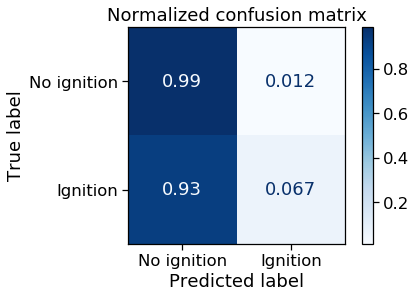

In [13]:
# Retrain default model with standard data sample size
model = XGBClassifier(
    n_jobs = max_jobs,
    scale_pos_weight = class_ratio,
    random_state = rand_seed
)

X_train, X_test, y_train, y_test = data_functions.make_train_test_sample(
    data, 
    sample_size, 
    train_test_split_ratio, 
    rand_seed
)

model.fit(X_train, y_train)

# Plot confusion matrix
class_names = np.array(['No ignition', 'Ignition'])
plotting_functions.display_confusion_matrix(model, class_names, X_test, y_test)

In [14]:
# Calculate false positive and negative rates
false_neg_rate, false_pos_rate = data_functions.calc_false_neg_pos_rate(model, X_test, y_test)
print("False negative rate: {}".format(np.round(false_neg_rate, 2)))
print("False positive rate: {}".format(np.round(false_pos_rate, 2)))

False negative rate: 0.03
False positive rate: 0.01


Given the nature of the problem, false negative are more dangerous than false positives. Although our false negative rate is under 10%, even with this small sample, we missed a significant number of fires. Needless to say, there is room for improvement here.

## Metaparameter optimization: to smooth or not to smooth

You may have notices that I loaded three different datasets at the start of this notebook:

1. **raw_data:** No significant manipulations beyond collating the various datasets. Has a time resolution of 3 hr. due to the frequency of the original NOAA weather data set.
2. **data_rolling_window:** Data was reversed with regard to time and then averaged with a 6 hr. rolling window. This has the effect of assigning the window mean to the time bin at the left of the window. This was done because logically we should care more about weather conditions before the fire was discovered than after.
3. **data_daily_mean:** Rolling window data was averaged by day.

**Note:** All averaging includes the boolean ignition value. After averaging is complete any noxel with a non-zero ignition value is reassigned a 1. This tends to make the fires discovery 'spread' to earlier times. Again, this is acceptable and even desirable because logically the fire must have started before it was discovered.

For more details about these three datasets take a look at the [data preprocessing notebook](https://github.com/gperdrizet/wildfire/blob/master/notebooks/preprocess_data.ipynb).

OK, so, let's compare the three sets with cross validation.

In [15]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28752480 entries, 0 to 28752479
Data columns (total 20 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date_time  datetime64[ns]
 1   lat        float32       
 2   lon        float32       
 3   air.2m     float32       
 4   apcp       float32       
 5   crain      float32       
 6   rhum_2m    float32       
 7   dpt_2m     float32       
 8   pres_sfc   float32       
 9   uwnd_10m   float32       
 10  vwnd_10m   float32       
 11  veg        float32       
 12  lcdc       float32       
 13  hcdc       float32       
 14  mcdc       float32       
 15  vis        float32       
 16  ignition   float32       
 17  year       float32       
 18  month      float32       
 19  day        float32       
dtypes: datetime64[ns](1), float32(19)
memory usage: 2.2 GB


In [16]:
# Roll data with windowed mean
data_rolling_window = raw_data.iloc[::-1]
data_rolling_window = data_rolling_window.groupby(['lat', 'lon']).rolling(48, on="date_time").mean()
data_rolling_window.reset_index(drop=True, inplace=True)
data_rolling_window.drop('date_time', axis=1, inplace=True)

# Reassign fractional ignition values a '1'
ignitions = data_rolling_window[data_rolling_window['ignition'] > 0].copy()
no_ignitions = data_rolling_window[data_rolling_window['ignition'] == 0].copy()
ignitions['ignition'] = 1

data_rolling_window = ignitions.append(no_ignitions)

In [17]:
# Average data by day
data_daily_mean = data_rolling_window.groupby([
    'lat', 
    'lon', 
    'year',
    'month',
    'day'
]).mean().reset_index()

data_daily_mean.reset_index(drop=True, inplace=True)

# Reassign fractional ignition values a '1'
ignitions = data_daily_mean[data_daily_mean['ignition'] > 0].copy()
no_ignitions = data_daily_mean[data_daily_mean['ignition'] == 0].copy()
ignitions['ignition'] = 1

data_daily_mean = ignitions.append(no_ignitions)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28752480 entries, 0 to 28752479
Data columns (total 17 columns):
 #   Column    Dtype  
---  ------    -----  
 0   lat       float32
 1   lon       float32
 2   month     float32
 3   air.2m    float32
 4   apcp      float32
 5   rhum_2m   float32
 6   dpt_2m    float32
 7   pres_sfc  float32
 8   uwnd_10m  float32
 9   vwnd_10m  float32
 10  vis       float32
 11  lcdc      float32
 12  hcdc      float32
 13  mcdc      float32
 14  crain     float32
 15  veg       float32
 16  ignition  float32
dtypes: float32(17)
memory usage: 1.8 GB


In [19]:
data_rolling_window.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28733210 entries, 47 to 28752479
Data columns (total 19 columns):
 #   Column    Dtype  
---  ------    -----  
 0   lat       float64
 1   lon       float64
 2   air.2m    float64
 3   apcp      float64
 4   crain     float64
 5   rhum_2m   float64
 6   dpt_2m    float64
 7   pres_sfc  float64
 8   uwnd_10m  float64
 9   vwnd_10m  float64
 10  veg       float64
 11  lcdc      float64
 12  hcdc      float64
 13  mcdc      float64
 14  vis       float64
 15  ignition  float64
 16  year      float64
 17  month     float64
 18  day       float64
dtypes: float64(19)
memory usage: 4.3 GB


In [20]:
data_daily_mean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28408472 entries, 0 to 28408471
Data columns (total 19 columns):
 #   Column    Dtype  
---  ------    -----  
 0   lat       float64
 1   lon       float64
 2   year      float64
 3   month     float64
 4   day       float64
 5   air.2m    float64
 6   apcp      float64
 7   crain     float64
 8   rhum_2m   float64
 9   dpt_2m    float64
 10  pres_sfc  float64
 11  uwnd_10m  float64
 12  vwnd_10m  float64
 13  veg       float64
 14  lcdc      float64
 15  hcdc      float64
 16  mcdc      float64
 17  vis       float64
 18  ignition  float64
dtypes: float64(19)
memory usage: 4.2 GB


In [21]:
# Loop over dataset list, run k-fold cross validation on stratified training sample
# from each. Report raw scores.

dataset_descriptions = [
    "Raw data",
    "Rolling window",
    "Daily average"
]

datasets = (
    data,
    data_rolling_window,
    data_daily_mean
)

classifier = XGBClassifier(
    n_jobs = max_jobs,
    scale_pos_weight = class_ratio,
    random_state = rand_seed
)

# Start empty dataframe to hold results
dataset_comparison_results = pd.DataFrame(columns=[
    'Data type',
    'Raw scores',
])

# Loop on datasets
for dataset, description in zip(datasets, dataset_descriptions):
    
    cross_val_scores = []
    
    for i in range(repetitions):
  
        # Draw train-test sample from dataset
        X_train, X_test, y_train, y_test = data_functions.make_train_test_sample(
            dataset, 
            sample_size, 
            train_test_split_ratio, 
            rand_seed
        )

        # Crossvalidate on training data
        scores = data_functions.cross_validate_classifier(
            classifier, 
            X_train, 
            y_train, 
            cv_folds, 
            scoring_func
        )
        
        cross_val_scores.append(scores)

    # Store raw scores
    dataset_comparison_results = dataset_comparison_results.append(pd.Series([
        description,
        cross_val_scores,
    ], index=dataset_comparison_results.columns), ignore_index=True)

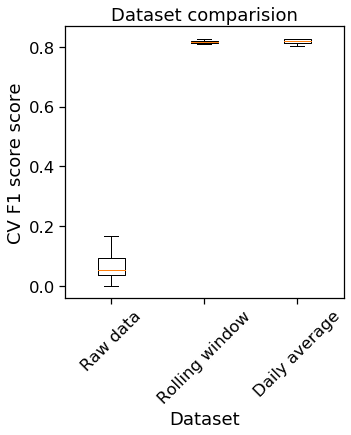

In [22]:
# Plot comparision of datasets by score
fig = plt.figure(1, figsize=(5, 5))
ax = fig.add_subplot(111)

bp = ax.boxplot(dataset_comparison_results['Raw scores'])
ax.set_xticklabels(dataset_comparison_results['Data type'])
plt.xlabel('Dataset')
plt.ylabel('CV {} score'.format(scoring_func_name))
plt.title('Dataset comparision')
plt.xticks(rotation=45)
plt.show()

Ok, looks like the daily averages are the winner, though the rolling window is close. Before moving on, let's see what happens if we try to optimize the rolling window width.

## Metaparameter optimization: rolling window width

The use of a rolling window introduces a possibly extremely important metaparameter: the rolling window width. Let's play with that next.

In [ ]:
# Loop over rolling window sizes, run k-fold cross validation on stratified 
# training sample for each. Report raw scores, false positive and false negative rates.

window_widths = range(2, 10, 1)

classifier = XGBClassifier(
    n_jobs = max_jobs,
    scale_pos_weight = class_ratio,
    random_state = rand_seed
)

# Start empty dataframe to hold results
model_scores = pd.DataFrame(columns=[
    'Window width',
    'CV {} score'.format(scoring_func_name),
    'CV False positive rate',
    'CV False negative rate'
])

# Loop over window width
for window_width in window_widths:
    
    # Roll dataset with window 
    data_rolling_window = raw_data.iloc[::-1]
    data_rolling_window = data_rolling_window.groupby(['lat', 'lon']).rolling(window_width, on="date_time").mean()
    data_rolling_window.reset_index(drop=True, inplace=True)
    data_rolling_window.drop('date_time', axis=1, inplace=True)
    
    ignitions = data_rolling_window[data_rolling_window['ignition'] > 0].copy()
    no_ignitions = data_rolling_window[data_rolling_window['ignition'] == 0].copy()
    ignitions['ignition'] = 1

    dataset = ignitions.append(no_ignitions)
    
    # Draw train-test sample from dataset
    X_train, X_test, y_train, y_test = data_functions.make_train_test_sample(
        dataset, 
        sample_size, 
        train_test_split_ratio, 
        rand_seed
    )
    
    # Run cross validation on traing data
    cross_val_scores = data_functions.cross_validate_classifier(
        classifier, 
        X_train, 
        y_train, 
        cv_folds, 
        scoring_func
    )

    score = mean(cross_val_scores)
    
    # Run cross validation with false positive rate
    cross_val_FP_rates = data_functions.cross_validate_classifier(
        classifier, 
        X_train, 
        y_train, 
        cv_folds, 
        make_scorer(data_functions.FP_rate_scorer)
    ) 

    cross_val_FP_rate = mean(cross_val_FP_rates)

    # Run cross validation with false negative rate
    cross_val_FN_rates = data_functions.cross_validate_classifier(
        classifier, 
        X_train, 
        y_train, 
        cv_folds, 
        make_scorer(data_functions.FN_rate_scorer)
    ) 

    cross_val_FN_rate = mean(cross_val_FN_rates)

    # Store results
    model_scores = model_scores.append(pd.Series([
        window_width,
        np.round(score,3), 
        np.round(cross_val_FP_rate,3), 
        np.round(cross_val_FN_rate,3)
    ], index=model_scores.columns), ignore_index=True)

In [ ]:
# Plot false positive and negative rates as a function of window size
plt.subplots(1, 2, figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(
    model_scores['Window width'], 
    model_scores['CV False negative rate'],
    color = "darkred",
    label = 'False negatives'
)

plt.scatter(
    model_scores['Window width'], 
    model_scores['CV False positive rate'],
    color = "darkblue",
    label = 'False positives'
)

plt.xlabel('Window width (hr.)')
plt.ylabel('Average CV rate')
plt.title('Window width vs. false classification')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(
    model_scores['Window width'], 
    model_scores['CV {} score'.format(scoring_func_name)],
    color = "darkgreen",
    label = 'False positives'
)
plt.xlabel('Window width (hr.)')
plt.ylabel('Average CV rate')
plt.title('Window width vs. CV {} score'.format(scoring_func_name))

plt.tight_layout()
plt.show()

## Hyperparameter optimization: class weight

One of the challenges inherent in this dataset is imbalanced classes. An appripriate class weight can help aleviate this. Also, one of the strange consequences of increasing the window width is an increase in the number of observations labeled fire. Now that we have the window width metaparameter nailed down, let's optimize the class weight.

In [ ]:
# Define class weight search space
class_weights = np.logspace(-2, 3, num=5, base=10)

# Run cross validation on each class weight, report score
# false positive and false negative rates
model_scores = data_functions.tune_class_weight(
    class_weights,
    max_jobs,
    rand_seed,
    data_daily_mean,
    repetitions,
    sample_size,
    train_test_split_ratio,
    cv_folds,
    scoring_func_name,
    scoring_func
)

In [ ]:
scoring_func_name

In [ ]:
scoring_func

In [ ]:
## Plot false positive rate, false negative rate and score
# as a function of class weight
plt.subplots(1,2,figsize=(12,5))

plt.subplot(1, 2, 1)
plt.scatter(
    np.log10(model_scores['Class weight']), 
    model_scores['CV False positive rate'],
    color = "darkblue",
    label = 'False positives'
)
plt.scatter(
    np.log10(model_scores['Class weight']), 
    model_scores['CV False negative rate'],
    color = "darkred",
    label = 'False negatives'
)
plt.xlabel('Log10 class weight ratio')
plt.ylabel('Cross validation rate')
plt.title('Class weight vs. false positives & negatives')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(
    np.log10(model_scores['Class weight']), 
    model_scores['CV {} score'.format(scoring_func_name)],
    color = "darkgreen",
    label ='CV {} score'.format(scoring_func_name),
)
plt.xlabel('Log10 class weight ratio')
plt.ylabel('CV {} score'.format(scoring_func_name))
plt.title('Class weight vs. {} score'.format(scoring_func_name))

plt.tight_layout()
plt.show()


Interesting. We can use larger class weights to drive down the false negative rate at the expense of false positives. Looking at the clearly sigmoidal score curve, the optimum value seems to be between 1 and 10.

In [ ]:
# Pick and store the class wight which gives the highest score
model_scores = model_scores.sort_values(['CV {} score'.format(scoring_func_name)], ascending=[0])
model_scores.reset_index(drop=True, inplace=True)
class_weight = model_scores.loc[0,'Class weight']
print("{} optimized class weight: {}".format(scoring_func_name,np.round(class_weight,2)))

**Note:** Important to keep in mind here that we can tune our false positive/false negative rates easily with this hyperparameter.

## Hyperparameter tuning: learning rate and tree count

First, let's try taking one sample of the full dataset and then using RandomizedSearchCV to try and find the best values for learning rate and tree count.

In [ ]:
# Define classifier whith all the hyperparameters we have determined so far
classifier = XGBClassifier(
    n_jobs = classifier_jobs,
    scale_pos_weight = class_weight,
    random_state = rand_seed
)

# Set search space
param_dist = {
    'learning_rate': loguniform(0.0001, 1),
    'n_estimators': range(1,200),
    'max_depth': range(1, 21, 1),
    'gamma': np.linspace(0, 10, 101),
    'min_child_weight': loguniform(0.0001, 10),
    'reg_lambda': loguniform(0.0001, 10)
    
}

# Run randomsearchCV
best_model, random_search = tune_hyperparameters(
    classifier,
    param_dist, 
    X_train, 
    y_train, 
    optimization_jobs, 
    grid_search_iterations, 
    scoring_func
)

In [ ]:
# Extract results to dataframe
rand_search_results = pd.DataFrame(random_search.cv_results_).dropna()

# Make desnity plot showing the dependenc of score on
# learning rate and n_estimators
x = rand_search_results['param_n_estimators']
y = rand_search_results['param_learning_rate']
z = rand_search_results['mean_test_score']
xi, yi, zi = regularize_grid(x, y, z, plot_grid_resolution)

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.contourf(xi, yi, zi, contourf_levels, cmap=plt.cm.Blues)
plt.xlabel("N estimators")
plt.ylabel("Learning rate")
plt.title("Effect of estimator count and \nlearning rate on score")
plt.colorbar()
plt.show()

Surprised by how 'rough' hyperparameter space is. Let's keep the winning numbers and save the scores to our log.

In [ ]:
best_learning_rate = rand_search_results.iloc[0]['param_learning_rate']
best_n_estimators = rand_search_results.iloc[0]['param_n_estimators']
print("{} optimized learning rate: {}".format(scoring_func_name,np.round(best_learning_rate,2)))
print("{} optimized n estimators: {}".format(scoring_func_name,np.round(best_n_estimators,2)))

best_depth = rand_search_results.iloc[0]['param_max_depth']
best_gamma = rand_search_results.iloc[0]['param_gamma']
print("{} optimized tree depth: {}".format(scoring_func_name,np.round(best_depth,2)))
print("{} optimized gamma: {}".format(scoring_func_name,np.round(best_gamma,2)))

best_min_child_weight = rand_search_results.iloc[0]['param_min_child_weight']
best_reg_lambda = rand_search_results.iloc[0]['param_reg_lambda']
print("{} optimized min. child weight: {}".format(scoring_func_name,np.round(best_min_child_weight,2)))
print("{} optimized L2 regularization: {}".format(scoring_func_name,np.round(best_reg_lambda,2)))

# Plot confusion matrix
class_names = np.array(['No ignition', 'Ignition'])
display_confusion_matrix(best_model, class_names, X_test, y_test)

## Hyperparameter tuning: tree depth and gamma

In [ ]:
# Define classifier whith all the hyperparameters we have determined so far
classifier = XGBClassifier(
    n_jobs = classifier_jobs,
    scale_pos_weight = class_weight,
    random_state = rand_seed,
    learning_rate = best_learning_rate,
    n_estimators = best_n_estimators
)

# Set search space
param_dist = {
    'max_depth': range(1, 21, 1),
    'gamma': np.linspace(0, 10, 101)
}

# Run randomsearchCV
best_model, random_search = tune_hyperparameters(
    classifier,
    param_dist, 
    X_train, 
    y_train, 
    optimization_jobs, 
    grid_search_iterations, 
    scoring_func
)

In [ ]:
# Extract results to dataframe
rand_search_results = pd.DataFrame(random_search.cv_results_).dropna()

# Make desnity plot showing the dependenc of score on
# learning rate and n_estimators
x = rand_search_results['param_max_depth']
y = rand_search_results['param_gamma']
z = rand_search_results['mean_test_score']
xi, yi, zi = regularize_grid(x, y, z, plot_grid_resolution)

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.contourf(xi, yi, zi, contourf_levels, cmap=plt.cm.Blues)
plt.xlabel("Tree depth")
plt.ylabel("Gamma")
plt.title("Effect of tree depth and gamma on score")
plt.colorbar()
plt.show()

Again store winning parameter for later use.

In [ ]:
best_depth = rand_search_results.iloc[0]['param_max_depth']
best_gamma = rand_search_results.iloc[0]['param_gamma']
print("F1 optimized tree depth: {}".format(np.round(best_depth,2)))
print("F1 optimized gamma: {}".format(np.round(best_gamma,2)))

## Feature importance

Now that we have our hyperparameters nailed down, let't take a look at feature importance. First thing to do is train our optimized model on the whole dataset.

In [ ]:
# Train with tuned hyperparameters
classifier = XGBClassifier(
    n_jobs = max_jobs,
    scale_pos_weight = class_weight,
    learning_rate = best_learning_rate,
    n_estimators = best_n_estimators,
    random_state = rand_seed,
    max_depth = best_depth,
    gamma = best_gamma
)

X_train, X_test, y_train, y_test = make_train_test_sample(
    data_daily_mean, 
    sample_size, 
    train_test_split_ratio, 
    rand_seed
)

# Train model
classifier.fit(X_train, y_train)

# Plot confusion matrix
class_names = np.array(['No ignition', 'Ignition'])
display_confusion_matrix(classifier, class_names, X_test, y_test)

In [ ]:
false_neg_rate, false_pos_rate = calc_false_neg_pos_rate(classifier, X_test, y_test)
print("False negative rate: {}".format(np.round(false_neg_rate, 2)))
print("False positive rate: {}".format(np.round(false_pos_rate, 2)))

In [ ]:
plot_relative_feature_importance(classifier, data_daily_mean, X_test, 20)

Looks like only our top 5 or so features are actually contributing anything. Let's retrain using only those features.

In [ ]:
# grab top n feature names
feature_names = X_train.columns.tolist()
importances = classifier.feature_importances_.tolist()
indices = np.argsort(importances)[::-1].tolist()
bottem_n_features = [feature_names[i] for i in indices[8:-1]]

data_daily_mean.drop(bottem_n_features, axis=1, inplace=True)

X_train, X_test, y_train, y_test = make_train_test_sample(
    data_daily_mean, 
    sample_size, 
    train_test_split_ratio, 
    rand_seed
)

# rebuild training and test sets with feature subset
# X_train, X_test, y_train, y_test = make_train_test_sample(
#     data_daily_mean, 
#     len(data_daily_mean), 
#     train_test_split_ratio, 
#     rand_seed
# )

#X_train, X_test = scale_weather_variables(weather_variables, X_train, X_test)

# X_train_subset = X_train[top_n_features]
# X_test_subset = X_test[top_n_features]

# Train model
classifier.fit(X_train, y_train)

# Plot confusion matrix
class_names = np.array(['No ignition', 'Ignition'])
display_confusion_matrix(classifier, class_names, X_test, y_test)

In [ ]:
false_neg_rate, false_pos_rate = calc_false_neg_pos_rate(classifier, X_test, y_test)
print("False negative rate: {}".format(np.round(false_neg_rate, 2)))
print("False positive rate: {}".format(np.round(false_pos_rate, 2)))

## Final model: robustness
Let's see how our final model holds up to repeated sampling - are the scores variable? or are the consistent across samples?

In [ ]:
train_scores = list()
test_scores = list()
false_neg_rates = list()
false_pos_rates = list()

sample_size = 5000

for i in range(0, 10):
    # rebuild training and test sets with feature subset
    X_train, X_test, y_train, y_test = make_train_test_sample(
        data_daily_mean, 
        sample_size, 
        train_test_split_ratio, 
        rand_seed
    )
    
    #X_train, X_test = scale_weather_variables(weather_variables, X_train, X_test)
    
    #X_train_subset = X_train[top_n_features]
    #X_test_subset = X_test[top_n_features]

    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    
    train_score = f1_score(y_train, classifier.predict(X_train))
    test_score = f1_score(y_test, classifier.predict(X_test))
        
    false_neg_rate, false_pos_rate = calc_false_neg_pos_rate(classifier, X_test, y_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    false_neg_rates.append(false_neg_rate)
    false_pos_rates.append(false_pos_rate)

In [ ]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.subplots(1, 3, figsize=(25, 7))

plt.subplot(1, 3, 1)

ax = sns.kdeplot(train_scores, label="Training data", shade=True, color="darkblue")
ax = sns.kdeplot(test_scores, label="Test data", shade=True, color="darkred")
ax.set_title("{} score distributions\nrepeated samples".format(scoring_func_name))
ax.set(xlabel='{} score'.format(scoring_func_name), ylabel='Density')
plt.legend()
plt.legend(loc='upper left')

plt.subplot(1, 3, 2)

ax = sns.kdeplot(false_neg_rates, label="False negative", shade=True, color="darkblue")
ax = sns.kdeplot(false_pos_rates, label="False positive", shade=True, color="darkred")
ax.set_title("False positive and negative rates\nrepeated samples")
ax.set(xlabel='Rate', ylabel='Density')
plt.legend()

plt.subplot(1, 3, 3)

plt.scatter(false_neg_rates, false_pos_rates, s=50, color="darkblue")
plt.xlabel("False negative rate")
plt.ylabel("False positive rate")
plt.title("False positive vs false negative rate\nrepeated samples")

plt.show()

## Conclusion

Overall, XGBoost was selected as the best classifier for this problem. The initial model performance was improved by optimizing dataset smoothing and hyperparameters. Then feature importance was investigated and lowly important features pruned.

## Future work

The current model can likely be further improved in four ways:
1. Apply neural net based machine learning.
2. Add more features to the data such as: elevation, total fires at a location etc.
3. Reframe the problem as regression by calculating fire probability, rather than using a binary 'yes'-'no' approach.
4. Implement 'fully stratified sampling' i.e. choose samples for training, validation and testing such that the distribution of all factors in the sample match the parent dataset as closely as possible.